# Regret bounds

$\renewcommand{\R}{\mathbb{R}}$
In this experiment we test multiple adaptations of classical Online Convex Optimization (OCO) techniques in a simple Lost Sales Stochastic Inventory Problem, which is that of :
> Huh, W. T., & Rusmevichientong, P. (2009).<br />
> A nonparametric asymptotic analysis of inventory planning with censored demand.<br />
> Mathematics of Operations Research, 34(1), 103-123.

The game unfolds as follows:

* for t=1...
  * the current inventory level is $x_{t}\in\R_+$
  * the algorithm chooses the *order quantity* $q_t\in \R_+$
  * a demand $d_t$ from the $\text{Unif}[0,1]$ is drawn
  * <span style="color:red"> the cost  $c_t = h(x_t+q_t-d_t)^++p(d_t-(x_t+q_t))^+$ is incurred (with $p\geq h$)</span>
  * unmet demand is lost and the carry over is defined by $x_{t+1}=(x_t+q_t-d_t)^+$

Most of the algorithms we will consider implement *"base stock policies"* which are expressed in terms of the *target level*: $y_t=x_t+q_t$. Note that $q_t\geq 0$ is equivalent to $y_t\geq x_t$.

We consider the following algorithms:
### LostSalesOptimalPolicy
Given the knowledge of the (time-invariant) demand cumulative distribution function $F$, that is, $F(x)=\mathbb{P}(d_t \leq x)$ for all $t,x$. <br>
The optimal strategy in this problem (i.e. the sequence of actions achieving minimal expected cumulative cost) is defined through a constant base stock policy:
$$ y_t = S^* = F^{-1}\left(\frac{p}{h+p}\right) $$
See Paragraph 4.6.1 of (Fundamentals of Supply Chain Theory)

### TargetLevelOGD
* When `iterate_on_implemented_levels` is set to `False`, it implements:
$$
  \begin{cases}
  \hat{y}_{t+1} = \text{Proj}_{[0,M]}(\hat{y}_t-\eta_t \partial c_t(\hat{y}_t))\\
  y_{t+1} = \max\{x_{t+1},\hat{y}_{t+1}\}
  \end{cases}
$$
  This has been proposed by *Huh, W. T., & Rusmevichientong, P. (2009)* and has a provable expected static regret of order $\sqrt{T}$ for i.i.d demands.
* Otherwise, it implements:
  $$y_{t+1} = \text{Proj}_{[x_{t+1},M]}(y_t-\eta_t \partial c_t(y_t))$$


### TargetLevelLinearizedFTRL
* When `project_on_the_highest_dynamic_constraint` is set to `False`, it implements:
$$
y_{t+1} = \text{Proj}_{[x_{t+1},+\infty)}\left( y_1 -\eta_{t}\sum_{i=1}^{t-1}\partial c_t(y_t)\right)
$$

This corresponds to *Algorithm 7.2* of *A Modern Introduction to Online Learning* where the decision variable is $y_t$ with regularizers $\psi_t: y \mapsto (y-y_1)^2/(2\eta_{t-1}) + \iota_{\{y \geq x_{t+1} \}} $.

* Otherwise, 
$$
y_{t+1} = \text{Proj}_{[\max\{x_1,\dots, x_{t+1}\},+\infty)}\left( y_1 -\eta_{t}\sum_{i=1}^{t-1}\partial c_t(y_t)\right)
$$
This corresponds to *Algorithm 7.2* of *A Modern Introduction to Online Learning* where the decision variable is $y_t$ with regularizers $\psi_t: y \mapsto (y-y_1)^2/(2\eta_{t-1}) + \iota_{\{y \geq \max\{x_1,\dots, x_{t+1}\}\}} $.

---

Imports

In [1]:
%load_ext autoreload
%autoreload 2

from typing import List
from typing import Callable

import pandas as pd
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from cost_structures import CostStructure
from non_perishable_inventory_state import NonPerishableInventoryState

from policies.abstract_inventory_policy import AbstractInventoryPolicy
from policies.constant_base_stock import ConstantBaseStock
from policies.target_level_linearized_ftrl import TargetLevelLinearizedFTRL
from policies.target_level_ogd import TargetLevelOGD
from policies.lost_sales_optimal_policy import LostSalesOptimalPolicy
from policies.constant_order_quantity import ConstantOrderQuantity

experiment_name="stockout_experiment"

Inventory state initialization

In [2]:
nb_products = 1
lead_times = np.zeros(nb_products,dtype=int)
state = NonPerishableInventoryState(nb_products,lead_times,"LOST_SALES")

Demand generator definition

In [3]:
demand_upper_bound = 1
demand_rvs = [scipy.stats.uniform(loc=0,scale=demand_upper_bound) for k in range(nb_products)]
demand_mean = demand_rvs[0].mean()
def demands_generator() :
    yield np.array([demand_rvs[k].rvs() for k in range(nb_products)])

Costs initialization

In [4]:
fixed_costs = np.zeros(nb_products)
purchase_costs = np.zeros(nb_products)
holding_costs = np.ones(1)
stockout_costs = 9*np.ones(1)
cost_structure = CostStructure(nb_products,fixed_costs,purchase_costs,holding_costs,stockout_costs)
print("fixed_costs:{}\npurchase_costs:{}\nholding_costs:{}\nstockout_costs:{}".format(fixed_costs, purchase_costs, holding_costs, stockout_costs))

fixed_costs:[0.]
purchase_costs:[0.]
holding_costs:[1.]
stockout_costs:[9.]


Policies initialization

0. LinearedFTRL $1/\sqrt{t}$ (with increased constraints)
1. LinearedFTRL $1/\sqrt{t}$
2. LinearedFTRL $1/t$
3. OGD $1/\sqrt{t}$ (Huh2009) 
4. Optimal policy 
5. Constant Target Level
6. Zero Orders

In [5]:
def learning_rate_generator(power:float) -> Callable :
    return lambda t : demand_upper_bound/(max(holding_costs[0],stockout_costs[0])*np.power(t,power))

learning_rate_of_huh_2009 = lambda t : 1/(8*holding_costs[0]*np.sqrt(t))

policies : List[AbstractInventoryPolicy] =  [
    TargetLevelLinearizedFTRL([.0],[demand_upper_bound],learning_rate_generator(0.5), cost_structure,
        project_on_the_highest_dynamic_constraint=True, name=r"LinearizedFTRL $1/\sqrt{t}$ (with increased constraints)"),
    TargetLevelLinearizedFTRL([.0],[demand_upper_bound],learning_rate_generator(0.5), cost_structure,
        project_on_the_highest_dynamic_constraint=False, name=r"LinearizedFTRL $1/\sqrt{t}$"),
    TargetLevelLinearizedFTRL([.0],[demand_upper_bound], learning_rate_generator(1), cost_structure,
        project_on_the_highest_dynamic_constraint=False, name=r"LinearizedFTRL $1/t$"),
    TargetLevelOGD([.0],[demand_upper_bound],learning_rate_of_huh_2009, cost_structure,
        iterate_on_implemented_levels=False, name="OGD [Huh2009]"),
    LostSalesOptimalPolicy(purchase_costs, holding_costs, stockout_costs, discount_factor=1.0, demand_quantile_functions=[demand_rvs[k].ppf for k in range(nb_products)], name="OptimalStrategy"),
    ConstantBaseStock([demand_rvs[k].mean() for k in range(nb_products)], name="MeanDemandTargetLevel"),
    ConstantOrderQuantity(np.zeros(nb_products),name="ZeroOrders")
]

Optimal unconstrainted base-stock level: [0.9]


Running the simulations

In [6]:
nb_periods = 5000
for policy_id in tqdm(range(len(policies))) : 
    state.reset()
    cost_structure.reset()
    for t in tqdm(range(1,nb_periods+1)) :
        order_quantities = policies[policy_id].get_order_quantity(t,state)
        demands = next(demands_generator())
        state.step(t,order_quantities,demands)
        cost_structure.incur_cost(t,state,order_quantities)
    cost_structure.save_history_as_csv("{}/costs_{}.csv".format(experiment_name,policy_id))
    state.save_movements_as_csv("{}/movements_{}.csv".format(experiment_name,policy_id))

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

# Results

Best performing methods

In [7]:
total_cost = np.zeros(len(policies))
for policy_id in range(len(policies)) :
    total_cost[policy_id] = pd.read_csv("cost_histories/{}/costs_{}.csv".format(experiment_name,policy_id))[["holding_cost","stockout_cost"]].sum().sum()/nb_periods
sorted_policies = np.argsort(total_cost)
for i in range(len(policies)) :
    print("{}. {} : {}".format(i+1, str(policies[sorted_policies[i]]), total_cost[sorted_policies[i]]))

1. OptimalStrategy : 0.4500737466126402
2. LinearizedFTRL $1/\sqrt{t}$ (with increased constraints) : 0.47501665122467485
3. LinearizedFTRL $1/\sqrt{t}$ : 0.5711380302084692
4. LinearizedFTRL $1/t$ : 0.9730246576637975
5. MeanDemandTargetLevel : 1.2446306256704909
6. OGD [Huh2009] : 2.9963116251927504
7. ZeroOrders : 4.463582148823874


In [8]:
total_cost = np.zeros(len(policies))
for policy_id in range(len(policies)) :
    total_cost[policy_id] = pd.read_csv("cost_histories/{}/costs_{}.csv".format(experiment_name,policy_id))[["holding_cost","stockout_cost"]].sum().sum()/nb_periods
sorted_policies = np.argsort(total_cost)
for i in range(len(policies)) :
    print("{}. {} : {}".format(i+1, str(policies[sorted_policies[i]]), total_cost[sorted_policies[i]]))

1. OptimalStrategy : 0.4500737466126402
2. LinearizedFTRL $1/\sqrt{t}$ (with increased constraints) : 0.47501665122467485
3. LinearizedFTRL $1/\sqrt{t}$ : 0.5711380302084692
4. LinearizedFTRL $1/t$ : 0.9730246576637975
5. MeanDemandTargetLevel : 1.2446306256704909
6. OGD [Huh2009] : 2.9963116251927504
7. ZeroOrders : 4.463582148823874


### Average cost
$$
T\mapsto \frac{1}{T}\sum_{t=1}^T c(y_t,d_t)
$$

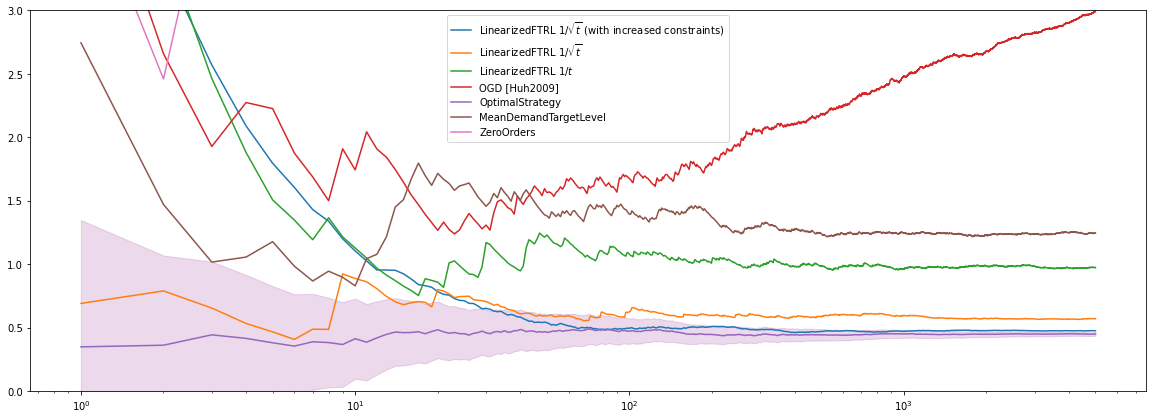

In [28]:
plt.figure(figsize=(20,7))
for policy_id in range(len(policies)) :
    x_ = np.arange(1,nb_periods+1)
    y_ = np.array(
        pd.read_csv("cost_histories/{}/costs_{}.csv".format(experiment_name,policy_id))
        .groupby("period")
        ["holding_cost","stockout_cost"]
        .sum()
        .sum(axis=1)
        .expanding()
        .mean()
    )
    plt.semilogx(x_,y_,label=str(policies[policy_id]))
    if(str(policies[policy_id]) == "OptimalStrategy") :
        band_ = 1/np.sqrt(x_)
        plt.fill_between(x_,y_-band_,y_+band_,alpha=0.15,color='purple')
plt.ylim((0,3))
plt.legend()
plt.show()

### Average regret compared to $S^*$
$$
T\mapsto \frac{1}{T}\sum_{t=1}^T c(y_t,d_t)-c(S^*,d_t)
$$

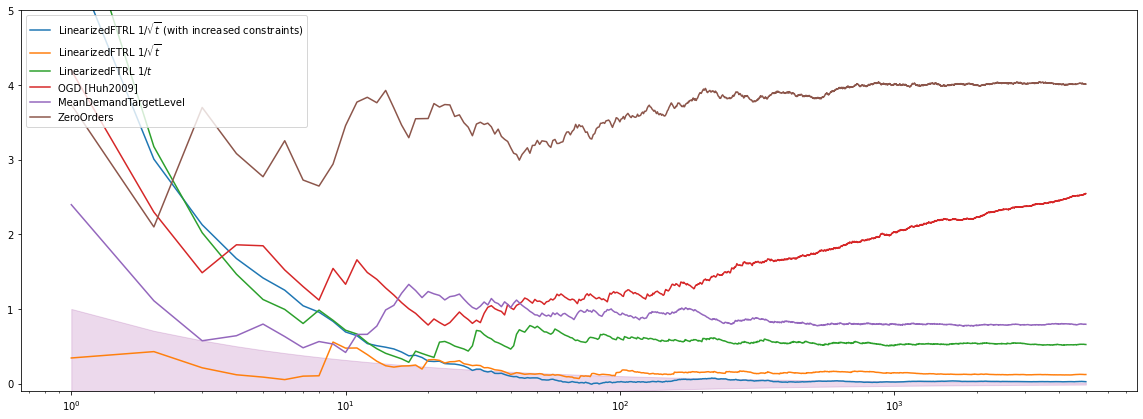

In [27]:
opt_ = np.array(
        pd.read_csv("cost_histories/{}/costs_{}.csv".format(experiment_name,4))
        .groupby("period")
        ["holding_cost","stockout_cost"]
        .sum()
        .sum(axis=1)
        .expanding()
        .mean()
    )
plt.figure(figsize=(20,7))
for policy_id in range(len(policies)) :
    x_ = np.arange(1,nb_periods+1)

    if(str(policies[policy_id]) == "OptimalStrategy") :
        band_ = 1/np.sqrt(x_)
        plt.fill_between(x_,-band_,band_,alpha=0.15,color='purple')
    else :
        y_ = np.array(
            pd.read_csv("cost_histories/{}/costs_{}.csv".format(experiment_name,policy_id))
            .groupby("period")
            ["holding_cost","stockout_cost"]
            .sum()
            .sum(axis=1)
            .expanding()
            .mean()
        )
        plt.semilogx(x_,y_-opt_,label=str(policies[policy_id]))
plt.ylim((-0.1,5))
plt.legend()
plt.show()

### Average of expected costs
$$
T\mapsto \frac{1}{T}\sum_{t=1}^T \mathbb{E}_{\tilde{d}} [c(y_t,\tilde{d})] = \frac{1}{T}\sum_{t=1}^T Q(y_t)
$$

In [11]:
def expected_instantaneous_cost(y:np.array) :
    return holding_costs[0]*(y-demand_upper_bound/2) + ( (holding_costs[0]+stockout_costs[0])/demand_upper_bound ) * (np.power(demand_upper_bound-y,2)/2)

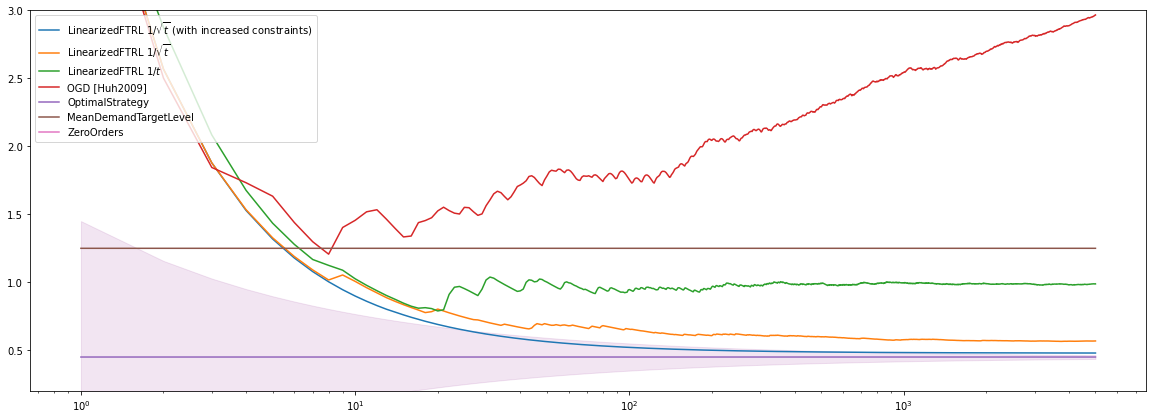

In [24]:
plt.figure(figsize=(20,7))
for policy_id in range(len(policies)) :
    x_ = np.arange(1,nb_periods+1)
    y_ = np.array(
        pd.read_csv("inventory_movements/{}/movements_{}.csv".format(experiment_name,policy_id))
        .groupby("period")
        ["interim_inventory_level"]
        .sum()
        .loc[1:nb_periods]
        .pipe(expected_instantaneous_cost)
        .expanding()
        .mean()
    )
    plt.semilogx(x_,y_,label=str(policies[policy_id]))
    if(str(policies[policy_id]) == "OptimalStrategy") :
        band_ = 1/np.sqrt(x_)
        plt.fill_between(x_,y_-band_,y_+band_,alpha=0.1,color="purple")
plt.ylim((0.2,3))
plt.legend()
plt.show()

### Average of expected costs compared to $S^*$
$$
T\mapsto \frac{1}{T}\sum_{t=1}^T Q(y_t)-Q(S^*)
$$

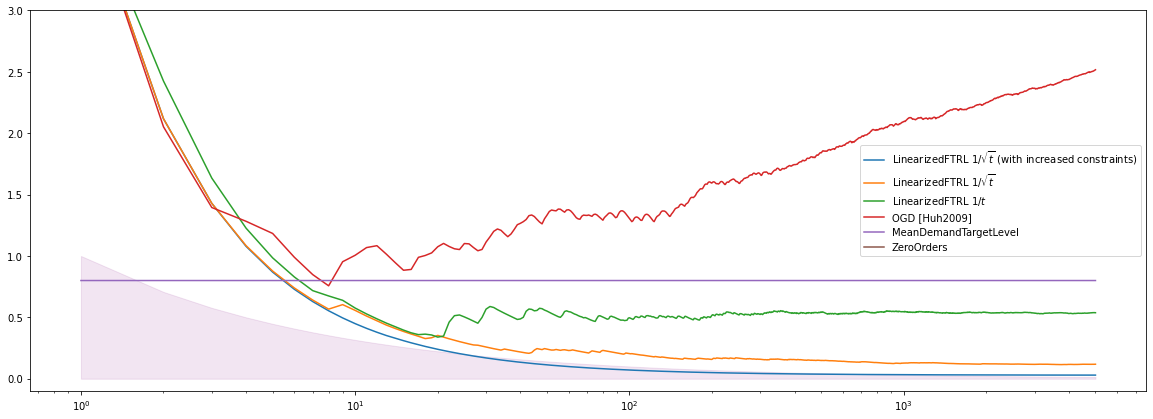

In [23]:
opt_ = np.array(
        pd.read_csv("inventory_movements/{}/movements_{}.csv".format(experiment_name, 4))
        .groupby("period")
        ["interim_inventory_level"]
        .sum()
        .loc[1:nb_periods]
        .pipe(expected_instantaneous_cost)
        .expanding()
        .mean()
    )
plt.figure(figsize=(20,7))
for policy_id in range(len(policies)) :
    x_ = np.arange(1,nb_periods+1)
    if(str(policies[policy_id]) == "OptimalStrategy") :
        band_ = 1/np.sqrt(x_)
        plt.fill_between(x_,0,band_,alpha=0.1,color="purple")
    
    else :
        y_ = np.array(
            pd.read_csv("inventory_movements/{}/movements_{}.csv".format(experiment_name, policy_id))
            .groupby("period")
            ["interim_inventory_level"]
            .sum()
            .loc[1:nb_periods]
            .pipe(expected_instantaneous_cost)
            .expanding()
            .mean()
        )
        plt.semilogx(x_,y_-opt_,label=str(policies[policy_id]))
plt.ylim((-0.1,3))
plt.legend()
plt.show()